In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
from IPython.display import clear_output

#Circuitos
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit.quantum_info import SparsePauliOp # Necesito un obsevable en concreto...

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, QFT
from qiskit.circuit import ParameterVector
from qiskit.utils import algorithm_globals


from sklearn.preprocessing import MinMaxScaler


from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

In [2]:
df=pd.read_csv('../datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])

df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

In [3]:
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

In [4]:
window = 12;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window

conjunto_train = []
objetivo_train = []

conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])
    
for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])

objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

In [5]:
scaler = MinMaxScaler((0.3, np.pi-0.3))
conjunto_train = scaler.fit_transform(conjunto_train)

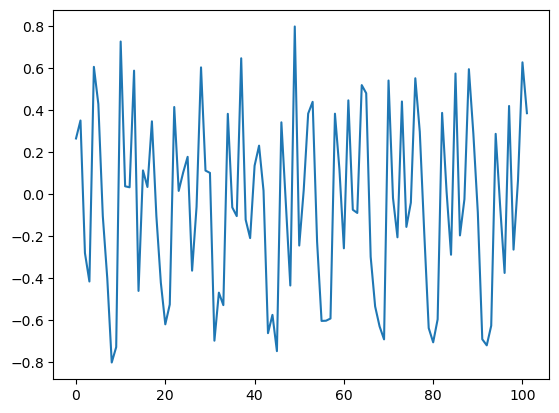

In [6]:
objetivo_train = (-1.6/(np.min(objetivo_train) - np.max(objetivo_train)))*objetivo_train - 0.8 + np.min(objetivo_train)*(1.6/(np.min(objetivo_train) - np.max(objetivo_train)))
plt.plot(objetivo_train)
plt.show()

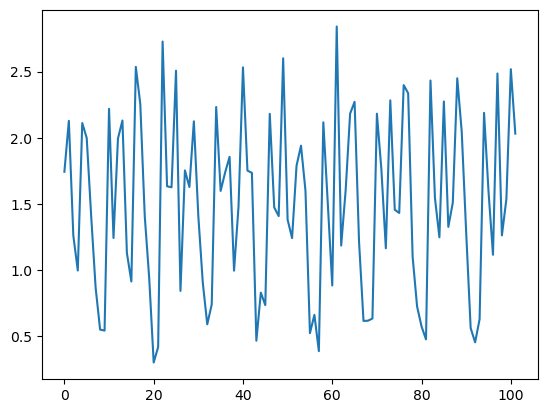

In [7]:
plt.plot(conjunto_train[:,0])
plt.show()

In [8]:
def circuitoRegresor_CodificacionAngular(n_qubits=1):
    qc = QuantumCircuit(n_qubits)
    
    inputs = ParameterVector("inputs",n_qubits)
    pesos = ParameterVector("pesos",6*n_qubits)
    feature_map = QuantumCircuit(n_qubits)
    feature_map.h(range(n_qubits))
    
    
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
    
    
    ansatz = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        ansatz.rx(pesos[i],i)
        
    for i in range(n_qubits):
        ansatz.ry(pesos[i+n_qubits],i)
        
    for i in range(n_qubits):
        ansatz.rz(pesos[i+2*n_qubits],i)
        
    for i in range(n_qubits-1):
        ansatz.cx(i,i+1)
        
    for i in range(n_qubits):
        ansatz.rx(pesos[i+3*n_qubits],i)
        
    for i in range(n_qubits):
        ansatz.ry(pesos[i+4*n_qubits],i)
        
    for i in range(n_qubits):
        ansatz.rz(pesos[i+5*n_qubits],i)
        
    for i in range(n_qubits-1):
        ansatz.cx(i,i+1)
        
    
    
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
    
    
    
    return feature_map.parameters, ansatz.parameters, qc, feature_map, ansatz

In [9]:
inputs, params, circuito, f1, f2 = circuitoRegresor_CodificacionAngular(window)

In [10]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [11]:
modeloEstimator = EstimatorQNN(
        circuit=circuito, input_params=inputs, weight_params=params
    )

In [12]:
regressor = NeuralNetworkRegressor(
    neural_network=modeloEstimator,
    loss='absolute_error' ,
    optimizer=COBYLA(maxiter=2000),
    callback=callback_graph
)

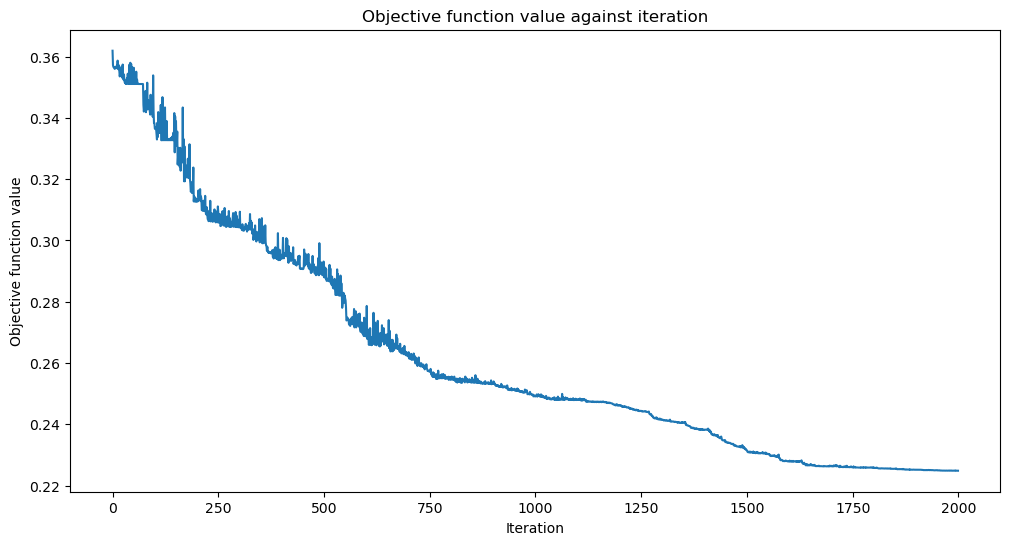

0.546704004624098

In [13]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(conjunto_train, objetivo_train)
regressor.score(conjunto_train, objetivo_train)

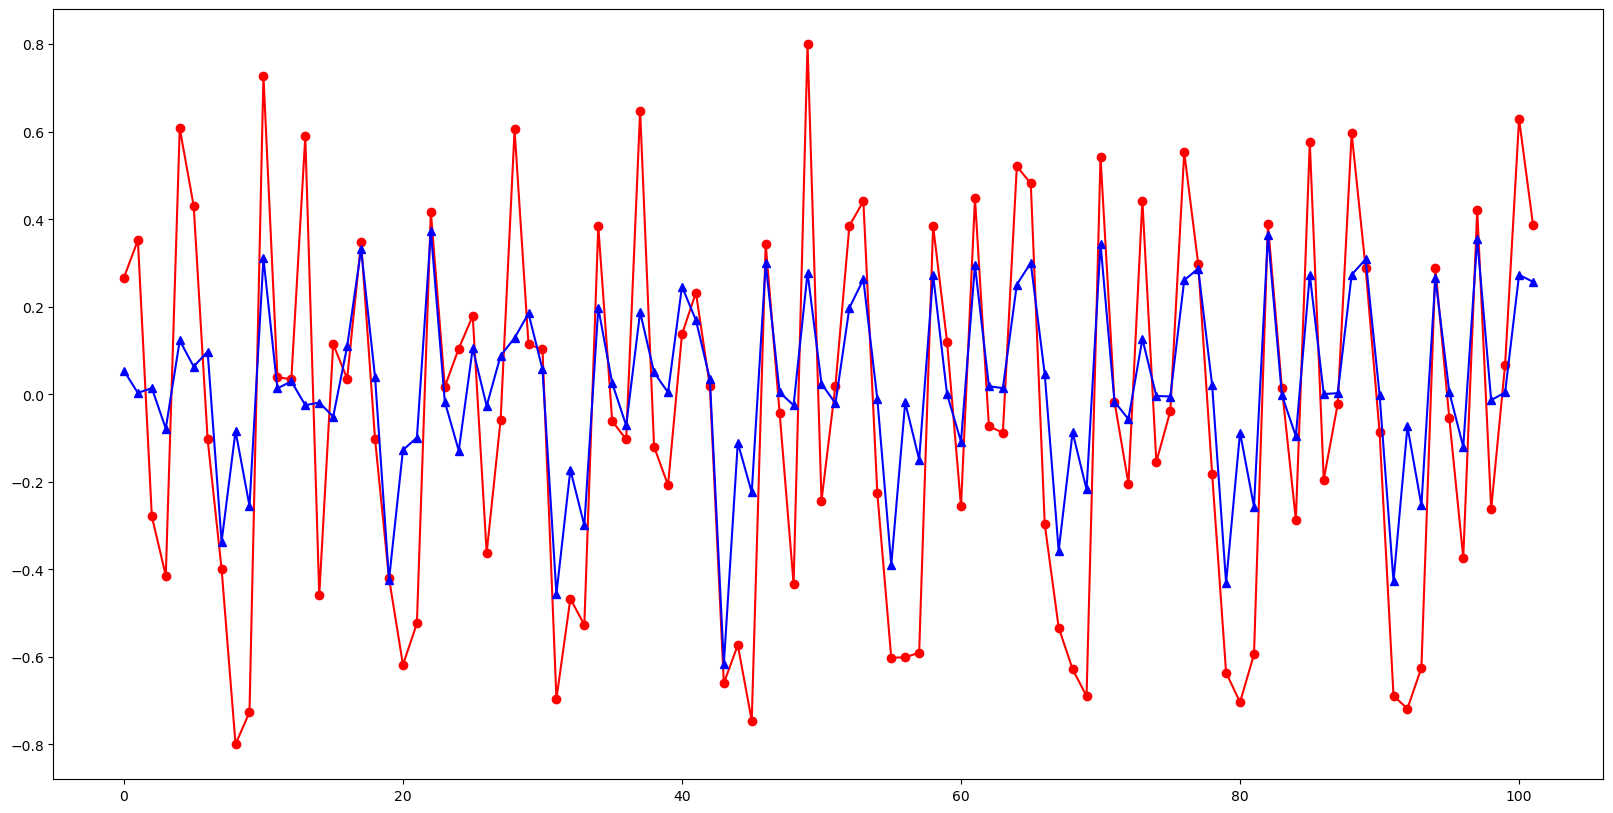

array([ 2.05678641e-01, -2.35725048e-03,  9.17516317e-03, -4.87383292e-02,
       -7.56102495e-02,  3.19325804e-03,  5.49911340e-02, -8.35059786e-03,
        4.75927602e-03,  2.70147384e-03, -4.72403906e-02, -3.06408354e-01,
        1.70349079e+00,  3.23545316e+00,  7.87611553e-01,  1.97720900e+00,
        3.01621108e+00,  8.13333584e-02, -7.44120103e-01,  4.46266057e-01,
        1.25101517e-01,  7.74221162e-02, -1.49937787e-01, -6.16794725e-01,
        1.75772030e+00,  9.83604782e-01,  6.60645076e-01,  1.96352606e+00,
       -1.95095325e-01, -3.46725504e-01,  1.64494275e+00,  1.28117043e+00,
        1.72579199e+00,  1.54064908e-01,  8.84192004e-01,  1.42076712e-01,
        1.15310117e+00,  1.00267155e-02, -4.69682853e-01, -2.28594557e-01,
        3.88151338e-01,  7.88433173e-02,  1.63416118e+00, -3.82848154e-02,
        9.16665694e-01, -4.09762844e-02,  5.78333277e-01,  2.96933485e-01,
        2.78010160e-01, -5.95272860e-02,  1.24214008e+00,  9.44654793e-02,
        6.42965854e-01, -

In [14]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = regressor.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor.weights

In [15]:
np.sum( np.abs(objetivo_train[:] - y_[:]))/(len(objetivo_train))

40.186194819959866

In [16]:
### NO HAY QUE HACER TRANSFORM conjunto_test = scaler.fit_transform(conjunto_test)
conjunto_test = scaler.transform(conjunto_test)

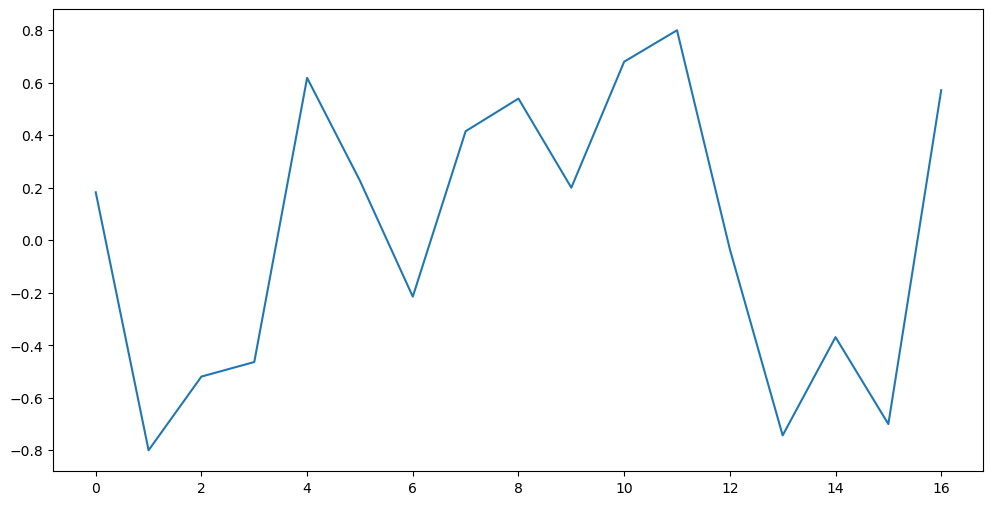

In [17]:
objetivo_test = (-1.6/(np.min(objetivo_test) - np.max(objetivo_test)))*objetivo_test - 0.8 + np.min(objetivo_test)*(1.6/(np.min(objetivo_test) - np.max(objetivo_test)))
plt.plot(objetivo_test)
plt.show()


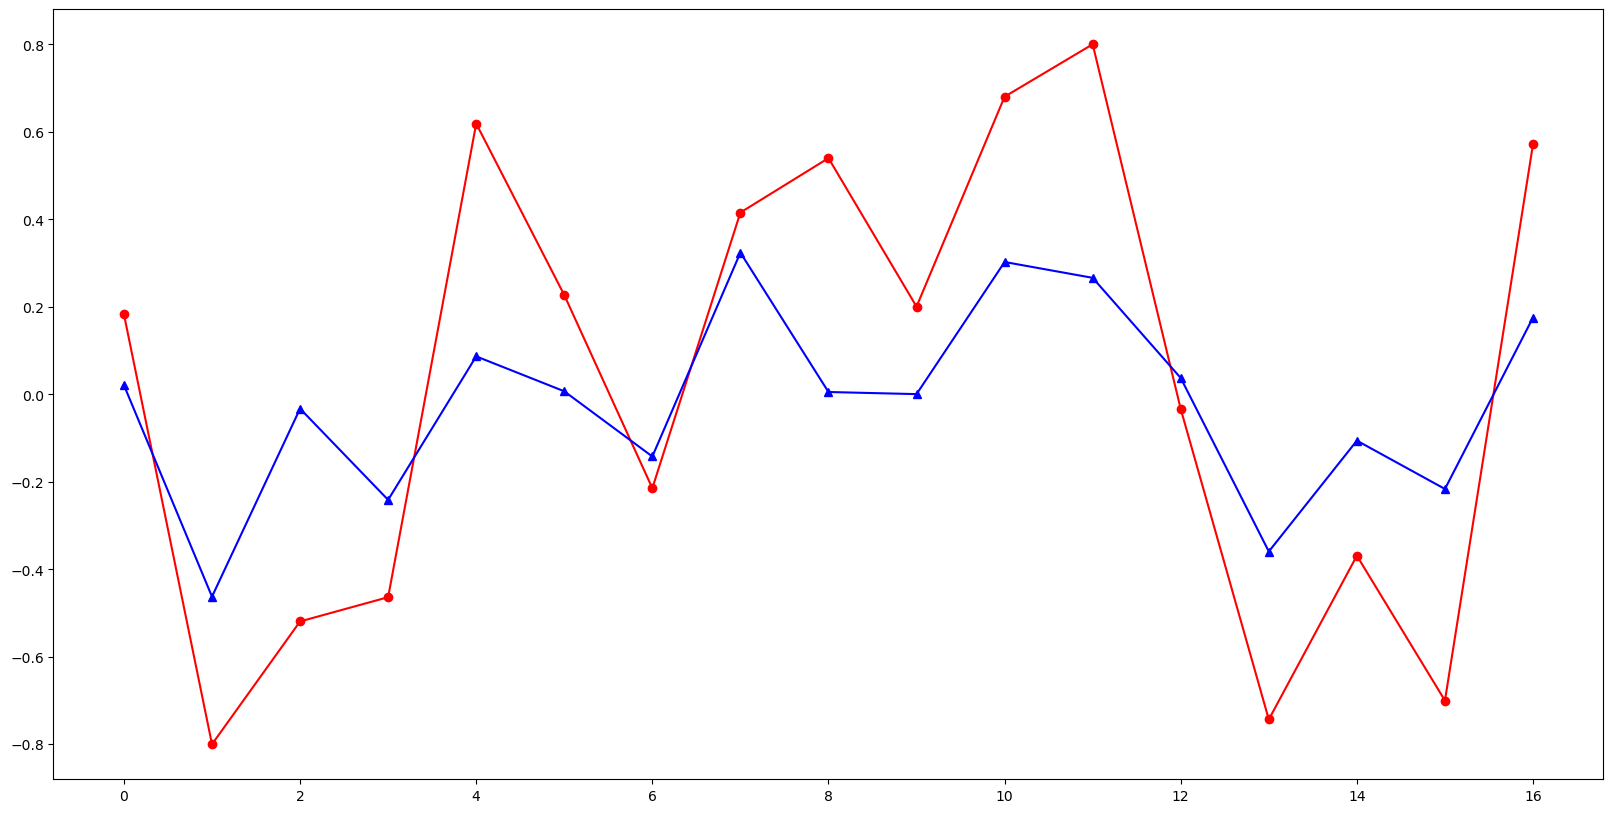

0.5493483657188246

In [18]:
espacio = np.arange(0,objetivo_test.shape[0])
y_ = regressor.predict(conjunto_test)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_test, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor.score(conjunto_test, objetivo_test)

In [19]:
np.sum( (objetivo_test[:] - y_[:])**2)/(len(objetivo_test))

5.5554002676132725